In [1]:
import pandas as pd

In [2]:
path='BigRoomContentsCluster.csv'

In [3]:
DATIS=pd.read_csv(path)

In [4]:
import numpy as np

In [5]:
DATIS['Label2']=np.where(DATIS['FinalFinalLab']=='table tables door doors','other',DATIS['FinalFinalLab'])

In [6]:
DATIS['Label2'].value_counts(normalize=True)

other                                                         0.210839
casework                                                      0.036849
bench entry                                                   0.012481
floor lights                                                  0.010931
table                                                         0.009892
                                                                ...   
circular mullion                                              0.000016
sdd lvl telecomm outlet                                       0.000016
autostrada worksurface rectilinear flush user edge tapered    0.000016
awi upper cabinet dbl door                                    0.000016
single door solid                                             0.000016
Name: Label2, Length: 727, dtype: float64

In [7]:
len(DATIS[DATIS['Label2']!='other'].drop_duplicates(['Name']))

46749

In [8]:
import re
def preprocessor(text): 
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

In [9]:
DATIS['Name'].apply(preprocessor)

0        steelcase turnstone  bivi  accessories  footshelf
1                accessoriesteknionjnamddrawer_moduler2015
2                            taaccessoriesfem nap disposer
3                                   accessories_walkoffmat
4           accessoriessecurityarmortexsprpackage_receiver
                               ...                        
60648                                         yoga_mat_dlr
60649                                          yoga studio
60650                                    yoga mat and ball
60651                                     yoga mat storage
60652                                   yoga storage bench
Name: Name, Length: 60653, dtype: object

In [10]:
DATIS['CleanName']=DATIS['Name'].str.replace('/',' ').replace({' +':' '},regex=True).apply(preprocessor)

In [11]:
len(DATIS['Name'].value_counts())-len(DATIS['CleanName'].value_counts())

366

In [12]:
DATIS['NameLen']=DATIS['Name'].str.len()
DATIS['RoomName']=DATIS['Name'].str.lower()
DATIS['TokenCount']=((DATIS['Name'].str.len()-DATIS['Name'].str.replace(' ','').str.len())+1)

<AxesSubplot:>

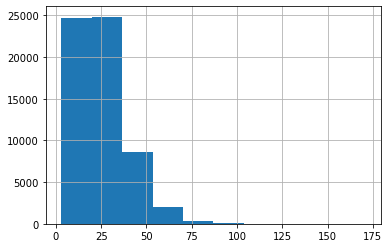

In [13]:
DATIS['NameLen'].hist()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

In [15]:
import pandas as pd
import numpy as np
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [16]:
DATIS.Label2=DATIS.Label2.str.lower()

In [17]:
DATIS['RoomType']=np.where((DATIS.Label2.str.contains('|'.join(['dining','laundry']))) | (DATIS.Label2=='junk'),'other',
                           np.where(DATIS.CleanName.str.contains('corridor'),'corridor vestibule',
                           DATIS['Label2']))

In [30]:
DATIS['Label2'].value_counts().head(275)

other                                     12788
casework                                   2235
bench entry                                 757
floor lights                                663
table                                       600
models                                      593
locker                                      566
desk desks office officer                   561
shower showers seat                         530
mirror                                      518
fixture lighting                            499
int frame                                   496
furniture                                   479
floor light                                 431
storage cabinet cabinets                    393
bar bars shelving                           375
panel                                       375
counter                                     330
trash waste                                 322
credenza                                    315
stairs stair escalator                  

In [24]:
pd.set_option('display.max_rows', 300)
DATIS.assign(dummy=1).drop_duplicates(['Label2','CleanName']).groupby(['Label2'])['dummy'].sum().reset_index().sort_values(by='dummy',ascending=False).query('dummy>40')

,Label2,dummy
494,other,12577
111,casework,2025
65,bench entry,690
335,floor lights,663
474,models,590
...,...,...
699,verb table,41
225,diffuser round,41
700,vert,41
596,shelving shelves mobile,41


In [19]:
binomiallist=[]
for i in range(0,len(DATIS)):
        binomiallist.append(np.random.binomial(1, .05))

In [20]:
DATIS['Keep']=binomiallist
DATIS['Keep']=np.where((DATIS['Label2']=='other'),DATIS['Keep'],1)

In [21]:
DATIS[(DATIS['Label2']=='other')]['Keep'].value_counts()

0    12141
1      647
Name: Keep, dtype: int64

In [22]:
DATIS2=DATIS[DATIS['Keep']==1]

In [23]:
DATIS2['Dummy']=1

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
len(DATIS2)

48499

In [25]:
DATIS2[['Name','Category','Total']].drop_duplicates()

,Name,Category,Total
0,Steelcase Turnstone - Bivi - Accessories - Foo...,Furniture,64
1,Accessories-Teknion-JNAMD-Drawer_Module-R2015,Furniture,12
2,ta-accessories-fem nap disposer,Specialty Equipment,6
3,Accessories_WalkoffMat,Generic Models,1
4,Accessories-Security-Armortex-SPR-Package_Rece...,Specialty Equipment,1
...,...,...,...
60648,Yoga_Mat_DLR,Specialty Equipment,1
60649,Yoga Studio,Casework,1
60650,Yoga Mat and Ball,Specialty Equipment,3
60651,Yoga Mat Storage,Casework,1


In [26]:
print(len(DATIS2[['Name','Category','Total']].drop_duplicates()))
print(len(DATIS2[['Name','Total']].drop_duplicates()))

48499
48300


In [28]:

from tqdm import tqdm

rowlist=list()

rows=list(DATIS2.reset_index(drop=True).index.values)

for i in tqdm(rows):
    
    multiplier=int(np.where(DATIS2.iloc[[i]]['Total']>50,50,DATIS2.iloc[[i]]['Total']))
    
    rowlist.append(pd.concat([DATIS2.iloc[[i]]]*multiplier))
    

100%|████████████████████████████████████████████████████████████████████████████| 48499/48499 [11:48<00:00, 68.44it/s]


In [31]:
DATIS2=pd.concat(rowlist,ignore_index=True)

In [32]:
DATIS2=DATIS2.rename(columns={'Label2':'InputType'})

In [216]:
size = 400        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
DATIS3=DATIS2.groupby('InputType', as_index=False).apply(fn).reset_index(drop=True)

In [226]:
DATIS2['Name']

0         steelcase turnstone  bivi  accessories  footshelf
1         steelcase turnstone  bivi  accessories  footshelf
2         steelcase turnstone  bivi  accessories  footshelf
3         steelcase turnstone  bivi  accessories  footshelf
4         steelcase turnstone  bivi  accessories  footshelf
                                ...                        
626853                                    yoga mat and ball
626854                                    yoga mat and ball
626855                                    yoga mat and ball
626856                                     yoga mat storage
626857                                   yoga storage bench
Name: Name, Length: 626858, dtype: object

In [217]:
y = DATIS3.InputType.str.lower()

In [228]:
y2=DATIS2.InputType.str.lower()

In [227]:
DATIS3['Name'] = DATIS3['CleanName']
DATIS2['Name'] = DATIS2['CleanName']

In [219]:
X = DATIS3['Name']

In [220]:
#DATIS2['ID']=DATIS2.reset_index(drop=True).index.values

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y ,test_size=0.25, random_state = 44)

In [222]:
len(y_train)

218100

In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [208]:

#finding

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


parameters = {
    
    'tfidf__ngram_range': ((1, 1)), 
    #'tfidf__max_df': (0.25,.275,.3,.325,.35,.375,.4,.425,.45,.475 ,0.5,.6,0.75, 1.0),
    #'tfidf__use_idf': (True, False),
    #'tfidf__sublinear_tf': (True, False),
    #'tfidf__smooth_idf' : (True, False),
    #'tfidf__min_df' : (1, 2,3),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.0001,0.001,0.01,1,10)
    #'clf__loss': ('log', 'perceptron'),
    #'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
    #'clf__penalty': ('l2', 'elasticnet','l1')

}


pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(max_df=.4,
                                         ngram_range=(1,1),
                                         use_idf=True,
                                         smooth_idf=False,
                                         sublinear_tf=False,
                                         min_df=1,
                                         norm='l2')),
               ('clf', SGDClassifier(loss='log',penalty='l1')),
              ])

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = grid_search.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))

TypeError: cannot unpack non-iterable int object

In [204]:
grid_search.best_params_

{'tfidf__ngram_range': (1, 1)}

In [107]:
#ToScore.to_csv('SpaceProgramClassed.csv')

In [224]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


tfidfvec=TfidfVectorizer(ngram_range=(1,1),max_df=.4,min_df=1,norm='l2',smooth_idf=True,sublinear_tf=False,use_idf=True)
mod=SGDClassifier(penalty='l1',loss='log')

#vectorizer.fit(X_train)
#X_train2=vectorizer.transform(X_train)
#X_test2=vectorizer.transform(X_test)




text_clf = Pipeline([ 
    ('tfidf', tfidfvec),
    ('clf', mod),
])


text_clf.fit(X_train, y_train)

#mod.fit(X_train2, y_train)

from sklearn.metrics import classification_report
#y_pred = mod.predict(X_test2)
y_pred2 = text_clf.predict(DATIS2[])
print('accuracy %s' % accuracy_score(y_pred2, y_test))
#print(classification_report(y_test, y_pred2))


#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred))

accuracy 0.5975240715268225


In [55]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
from onnxmltools import save_model
from onnxruntime import InferenceSession

In [56]:
onnx_model = convert_sklearn(text_clf,
name='JCRoomTypeClassifier',
initial_types=[('input', StringTensorType([1, 1]))]
)

save_model(onnx_model, 'JC.onnx')
sess = InferenceSession("JC.onnx")
label_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name

#res = sess.run(None, input_feed={'input': np.array([['corridor']])})

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\operator_converters\text_vectoriser.py:185: UserWarning: Converter for TfidfVectorizer will use scikit-learn regular expression by default in version 1.6.
  UserWarning)
C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\skl2onnx\common\_container.py:595: UserWarning: Unable to find operator 'Tokenizer' in domain 'com.microsoft' in ONNX, op_version is forced to 1.
  op_type, domain))


In [90]:
DATIS[DATIS['RoomName'].str.contains('court')]['RoomName'].value_counts()

std jury courtroom                                    229
std courtroom                                          70
juvenile courtroom                                     43
courtroom                                              22
court reporter                                         19
large trial courtroom                                  14
court room                                             13
court admin office                                      7
future courtroom                                        6
courtroom deputy b                                      6
courtyard                                               6
courts                                                  6
jury courtroom                                          6
courtroom deputy c                                      6
standard trial courtroom                                6
court                                                   6
courtroom deputy a                                      6
excerise court

In [84]:
sess.run(None, input_feed={'input': np.array([["Outdoor Exercise Court"]])})


[array(['court'], dtype=object),
 [{'bailiff': 0.0002894130884669721,
   'balcony': 0.00021149592066649348,
   'booking law': 0.00034584300010465086,
   'break room': 9.63763304753229e-05,
   'cart carts handling': 0.00030858570244163275,
   'chase': 0.0001596335059730336,
   'circulation': 0.0002786496770568192,
   'classroom': 1.543940743431449e-05,
   'closet jan': 0.0003261362435296178,
   'coffee cafe': 0.0003527702356223017,
   'communication communications telecom': 7.246812310768291e-05,
   'conference': 0.00024678430054336786,
   'control': 0.00025943160289898515,
   'cooler freezer freezers': 0.00026399255148135126,
   'corridor hallway': 0.00017339945770800114,
   'corridor vestibule': 0.00033005038858391345,
   'court': 0.4361991286277771,
   'courtyard outdoor': 0.00035659389686770737,
   'day room': 4.669848203775473e-05,
   'dental dentist': 0.00025839131558313966,
   'detox': 0.0003010625368915498,
   'dialysis': 0.0003901280288118869,
   'dinning': 0.000339760998031124

In [43]:
with open("TextClassifier1.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [42]:
res

[array(['services1'], dtype=object),
 [{'amenity': 0.07348394393920898,
   'circulation': 0.044751111418008804,
   'collaboration: closed': 0.07773763686418533,
   'collaboration: open': 0.04349435120820999,
   'desking: open workstation': 0.031024377793073654,
   'desking: private office': 0.049801651388406754,
   'lab': 0.04049787297844887,
   'services 2': 0.039142508059740067,
   'services1': 0.4987942576408386,
   'support': 0.10127229988574982}]]

In [79]:
matchdf=pd.DataFrame({'A':list(y_pred2[X_test.isin(list(X_train))==False]),
              'B':list(y_test[X_test.isin(list(X_train))==False])})

In [80]:
matchdf['C']=(matchdf['A']==matchdf['B'])*1

In [81]:
matchdf['D']=1

In [82]:
labels=list(matchdf.groupby(['A'])['D'].sum().index)

In [83]:
scores=list(matchdf.groupby(['A'])['C'].sum().values/matchdf.groupby(['A'])['D'].sum().values)

In [84]:
print('Accuracy:',matchdf['C'].sum()/matchdf['D'].sum())

Accuracy: 0.8950617283950617


In [85]:
pd.DataFrame({'Category':labels,'Guesses':list(matchdf.groupby(['A'])['D'].sum().values),'True Positive Rate':scores})

,Category,Guesses,True Positive Rate
0,art digital exist,10,0.600000
1,bathroom,32,0.843750
2,classroom,83,0.879518
3,collaboration student work,4,1.000000
4,common social collaboration,11,0.636364
5,conference resource collaboration,6,0.833333
6,corridor mail central,3,0.666667
7,lab exist flex,23,0.782609
8,locker athletic official,13,1.000000
9,mechanical yard auditorium,5,0.800000


C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 728, in fit
    sample_weight=sample_weight)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 541, in _fit
    accept_large_sparse=False)
  File "C:\Users\dmckenzie\Anaconda3\envs\Three Seven\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\dmckenzie\Anaconda3\e

<AxesSubplot:title={'center':'Classifier Validation Score As Training Data Grows'}, xlabel='Training Data Size', ylabel='Validation Score'>

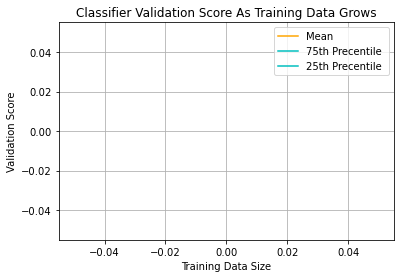

In [39]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

#np.random.seed(0)
#X, y = load_iris(return_X_y=True)
#indices = np.arange(y.shape[0])
#np.random.shuffle(indices)
#X, y = X[indices], y[indices]

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(penalty='l1',loss='log',alpha=0.00001),
                                                         X_train, y_train, train_sizes=[10,20,30,40,50,60,70,80,90,100,
                                                                                         110,120,130,140,150,160,170,180,190,200,
                                                                                         210,220,230,240,250,260,270,280,290,300,
                                                                                         310,320,330,340,350,360,370,380,390,400,
                                                                                        410,420,430],cv=5)
pd.DataFrame({'Mean':list(pd.DataFrame(valid_scores.transpose()).median()),
             '75th Precentile ':list(pd.DataFrame(valid_scores.transpose()).quantile(0.75)),
             '25th Precentile':list(pd.DataFrame(valid_scores.transpose()).quantile(0.25))},
             index=train_sizes).plot(color = ['orange', 'c','c'],
                                    xlabel='Training Data Size',ylabel='Validation Score',
                                     grid=True,title='Classifier Validation Score As Training Data Grows')

In [37]:
pd.DataFrame(valid_scores.transpose()).mean().plot()

NameError: name 'valid_scores' is not defined

In [38]:
pd.DataFrame(pd.DataFrame(valid_scores.transpose())).plot()

NameError: name 'valid_scores' is not defined